# Interacting with NeuroMechFly

**Summary:** In this tutorial, we will introduce the basic concepts of interacting with the simulated fly in a Markov Decision Process using the Gym interface. As a demonstration, we will kinematically replay the experimentally recorded walking behavior in the simulator.

Markov Decision Process (MDP) and the Gym API
---------------------------------------------

We formulated the control of NeuroMechFly as a partially observable Markov Decision Process (MDP). At each time step, the simulation provides the controller with an observation and, optionally, a user-defined reward. Then, the simulation receives an action from the controller and steps the physics forward accordingly. The observation space is a user-configurable subset of the state space including visual inputs, olfactory inputs, ground contacts, joint states (angles, angular velocities, and torques), and the position and velocity of the fly model within the arena. The action space includes the control signal (eg. angles for position control) for every actuated joint (eg. 7 degrees-of-freedom (DoFs) per leg * 6 legs) and the on/off signal for leg adhesion. This framework is easily extendable: the user can incorporate additional layers of sensory preprocessing or premotor computation into the MDP.

| ![](https://github.com/NeLy-EPFL/_media/blob/main/flygym/mdp.png?raw=true) | 
|:--:| 
| *The biomechanical model and its interaction with the environment are encapsulated as a MDP task. A user-defined controller interfaces with the task through actions (red) and observations (blue). The user can extend the MDP task by adding preprogrammed processing routines for sensory inputs (purple) and motor outputs (light blue), to modify the action and observation spaces handled by the controller.* |


Our implementation of the partially observable MDP complies with the [Gymnasium API](https://gymnasium.farama.org/). Gymnasium (a continuation of the now deprecated OpenAI Gym) is a package and standardized interface for developing and comparing control algorithms and benchmarking tasks. It provides a diverse collection of environments, ranging from classic control problems, Atari games, board games, and robotics simulations. Gym environments are designed to offer a common interface for controllers, in particular reinforcement learning agents, to interact with. This standardization makes it easier to develop and compare algorithms.

The overall steps for interacting with a Gym environment are:

1. Defining an environment
2. Reset the environment and get the initial observation
3. Interact with the environment with a loop:
   - Based on the last observation, the controller decides which actions to take
   - Step the simulation, applying the selected actions. The simulation will return you the new observation (and optionally some additional information)
   - Optional: render the simulation graphically
   - Break if certain conditions are met (eg. task is accomplished or failed), otherwise continue

4. Close the environment and analyze the results

This process can be shown in the following code snippet:

```Python
env = MyEnvironement(...)
obs, info = env.reset()

for step in range(1000):    # let's simulate 1000 steps max
    action = ...    # your controller decides what to do based on obs
    obs, reward, terminated, truncated, info = env.step(action)
    env.render()
    if terminated or truncated:
        break

env.close()
```

Note that the action can be selected by any means defined by the user (eg. preprogrammed rules, algorithmic models, artificial neural networks).

### The action and observation spaces
The **action** is a dictionary with the following keys and values:

- **"joints"**: The control signal for the actuated DoFs (eg. if ``NeuroMechFly.control == "position"``, then this is the target joint angle). This is a NumPy array of shape (|actuated_joints|,). The order of the DoFs is the same as ``NeuroMechFly.actuated_joints``.
- **"adhesion"** (if ``sim_params.enable_adhesion`` is True): The on/off signal of leg adhesion as a NumPy array of shape (6,), one for each leg. The order of the legs is: LF, LM, LH, RF, RM, RH (L/R = left/right, F/M/H = front/middle/hind).

The **observation** is a dictionary with the following keys and values:

- **"joints"**: The joint states as a NumPy array of shape (3, |actuated_joints|). The three rows are the angle, angular velocity, and force at each DoF. The order of the DoFs is the same as ``NeuroMechFly.actuated_joints``
- **"fly"**: The fly state as a NumPy array of shape (4, 3). 0th row: x, y, z position of the fly in arena. 1st row: x, y, z velocity of the fly in arena. 2nd row: orientation of fly around x, y, z axes. 3rd row: rate of change of fly orientation.
- **"contact_forces"**: Readings of the touch contact sensors, one placed for each of the body segments specified in ``NeuroMechFly.contact_sensor_placements``. This is a NumPy array of shape (|contact_sensor_placements|, 3)
- **"end_effectors"**: The positions of the end effectors (most distal tarsus link) of the legs as a NumPy array of shape (6, 3). The order of the legs is: LF, LM, LH, RF, RM, RH (L/R = left/right, F/M/H = front/middle/hind). 
- **"fly_orientation"**: NumPy array of shape (3,). This is the vector (x, y, z) pointing toward the direction that the fly is facing.
- **"vision"** (if ``sim_params.enable_vision`` is True): The light intensities sensed by the ommatidia on the compound eyes. This is a NumPy array of shape (2, num_ommatidia_per_eye, 2), where the zeroth dimension is the side (left, right in that order); the second dimension specifies the ommatidium, and the last column is for the spectral channel (yellow-type, pale-type in that order). Each ommatidia only has one channel with nonzero reading. The intensities are given on a [0, 1] scale.
- **"odor_intensity"** (if ``sim_params.enable_olfaction`` is True): The odor intensities sensed by the odor sensors (by default 2 antennae + 2 maxillary palps). This is a NumPy array of shape (odor_space_dimension, num_sensors).

### `terminated`, `truncated`, and the `info` dictionary
In the Gym API, the `step()` method returns a `terminated` flag indicating whether the simulation has ended due to a condition under the MDP formulation (eg. task success/failure). The `step()` method also returns a `truncated` flag indicating whether the simulation has ended due to a condition outside the MDP formulation (eg. timeout). The provided `NeuroMechFly` environment always returns False for both `terminated` and `truncated`. The user can modify this behavior by extending the `NeuroMechFly` class.

Additionally, the `step()` method returns an `info` dictionary that contains arbitrary auxillary information. The user can add any information to this dictionary by extending the `NeuroMechFly` class. The provided `NeuroMechFly` contains the following keys and values in the **`info` dictionary**:

- **"raw_vision"** (if ``sim_params.enable_vision`` and ``sim_params.render_raw_vision`` are both True): The eye camera rendering before it is transformed into ommatidia readings. This is a NumPy array of shape (2, nrows, ncols, 3) where the zeroth dimension is for the side (left, right in that order). The rest are the RGB image.

## Example: Kinematic replay of experimentally recorded behavior

We now move on to an example where we kinematically replay some experimentally recorded walking behaviors. Precisely, we record a tethered fly walking on an air-suspended spherical treadmill using 7 zoomed-in cameras from different angles. We then estimate the positions of joint keypoints in 3D using DeepFly3D (Günel et al, 2019) and use inverse kinematics to calculate the angle at each DoF. Then, we will use a PD controller to actuate the DoFs on the simulated fly at with these exact angles to see if the fly can walk on flat terrain untethered, as shown in the original NeuroMechFly paper (Lobato-Rios et al, 2022).

We start with the necessary imports:

In [1]:
import numpy as np
import pickle
import matplotlib.pyplot as plt
from pathlib import Path
from tqdm import trange

import flygym.common
import flygym.mujoco
import flygym.mujoco.preprogrammed

Let's define some simulation parameters:

In [2]:
run_time = 1
sim_params = flygym.mujoco.Parameters(
    timestep=1e-4, render_mode="saved", render_playspeed=0.2, draw_contacts=True
)
actuated_joints = flygym.mujoco.preprogrammed.all_leg_dofs

We can now load the recorded kinematics that is included with the FlyGym package:

In [3]:
data_path = flygym.common.get_data_path("flygym", "data")
with open(data_path / "behavior" / "210902_pr_fly1.pkl", "rb") as f:
    data = pickle.load(f)

The dataset is provided at 2000 Hz. We will try to run the simulation at $\Delta t=0.0001s$ (10000 Hz), so let's interpolate it 5x:

In [4]:
target_num_steps = int(run_time / sim_params.timestep)
data_block = np.zeros((len(actuated_joints), target_num_steps))
input_t = np.arange(len(data["joint_LFCoxa"])) * data["meta"]["timestep"]
output_t = np.arange(target_num_steps) * sim_params.timestep
for i, joint in enumerate(actuated_joints):
    data_block[i, :] = np.interp(output_t, input_t, data[joint])

We can visualize the time series of DoF angles:

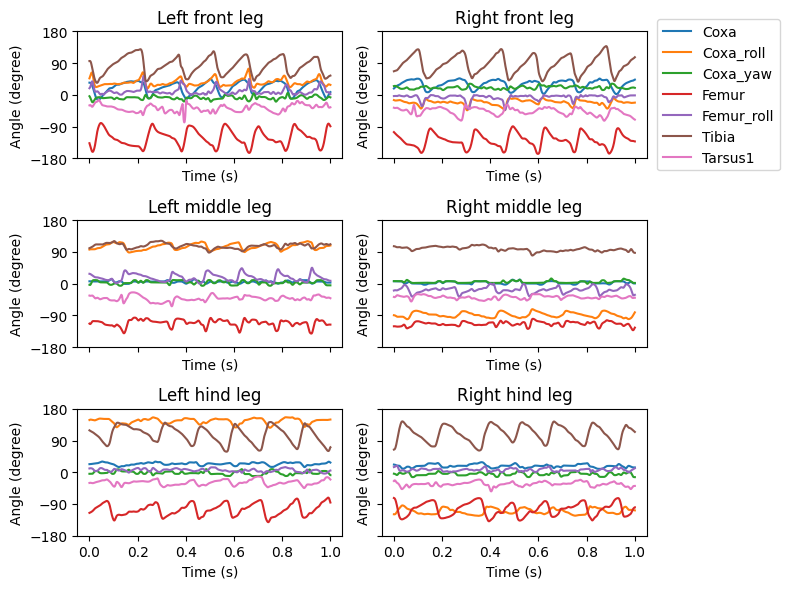

In [5]:
fig, axs = plt.subplots(
    3, 2, figsize=(8, 6), sharex=True, sharey=True, tight_layout=True
)
legs = [
    f"{side} {pos} leg"
    for pos in ["front", "middle", "hind"]
    for side in ["Left", "Right"]
]
for i, leg in enumerate(legs):
    ax = axs.flatten()[i]
    leg_code = f"{leg.split()[0][0]}{leg.split()[1][0]}".upper()
    for j, dof in enumerate(actuated_joints):
        if dof.split("_")[1][:2] != leg_code:
            continue
        ax.plot(output_t, np.rad2deg(data_block[j, :]), label=dof[8:])
    ax.set_ylim(-180, 180)
    ax.set_xlabel("Time (s)")
    ax.set_ylabel("Angle (degree)")
    ax.set_yticks([-180, -90, 0, 90, 180])
    ax.set_title(leg)
    if leg == "Right front leg":
        ax.legend(bbox_to_anchor=(1.04, 0.5), loc="center left", borderaxespad=0)

Path("outputs/").mkdir(exist_ok=True)
fig.savefig("outputs/kin_replay_joint_dof_time_series.png")

Now we can create a NeuroMechFly simulation instance and play out the recorded kinematics in the MDP loop:

In [6]:
nmf = flygym.mujoco.NeuroMechFly(
    sim_params=sim_params,
    init_pose="stretch",
    actuated_joints=actuated_joints,
    control="position",
)
obs, info = nmf.reset()
for i in trange(target_num_steps):
    # here, we simply use the recorded joint angles as the target joint angles
    joint_pos = data_block[:, i]
    action = {"joints": joint_pos}
    obs, reward, terminated, truncated, info = nmf.step(action)
    nmf.render()

100%|██████████| 10000/10000 [00:16<00:00, 608.34it/s]


To save the rendered video:

In [7]:
nmf.save_video("./outputs/kinematic_replay.mp4")

<video src="https://raw.githubusercontent.com/NeLy-EPFL/_media/main/flygym/kinematic_replay.mp4" controls="controls" style="max-width: 730px;"></video>

We can inspect the observation at the last step to see if they are consistent with our expectation:

In [8]:
for k, v in obs.items():
    print(f"{k}: shape {v.shape}")

joints: shape (3, 42)
fly: shape (4, 3)
contact_forces: shape (30, 3)
end_effectors: shape (6, 3)
fly_orientation: shape (3,)


The basic NeuroMechFly simulation always returns 0 as the reward. It always returns False for the `terminated` and `truncated` flags. The `info` is also empty. The user can extend the `NeuroMechFly` class to modify these behaviors.

In [9]:
print(f"reward: {reward}")
print(f"terminated: {terminated}")
print(f"truncated: {truncated}")
print(f"info: {info}")

reward: 0
terminated: False
truncated: False
info: {}
